# Convolutional Neural Network

### Importing the libraries

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
tf.__version__

'2.18.0'

## Part 1 - Data Preprocessing

In [120]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

### Processando o TrainSet

In [121]:
training_set = tf.keras.utils.image_dataset_from_directory(
    'dataset/',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,)

Found 2615 files belonging to 3 classes.
Using 2092 files for training.


### Processando o TestSet

In [122]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    'dataset/',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,)

Found 2615 files belonging to 3 classes.
Using 2092 files for training.


#### Primeiras 9 imagens

In [123]:
class_names = training_set.class_names
print(class_names)

['Cercosporiose', 'Ferrugem', 'Saudavel']


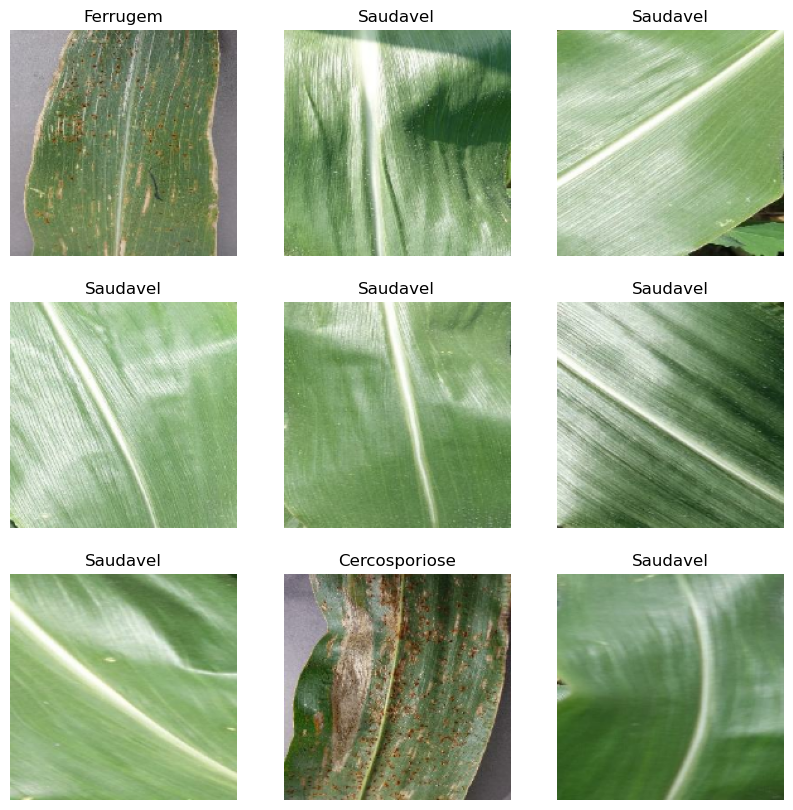

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configurando o conjunto de dados

In [125]:
AUTOTUNE = tf.data.AUTOTUNE

training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

## Padronizando os dados

In [126]:
normalization_layer = layers.Rescaling(1./255)

In [127]:
normalized_ds = training_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Construíndo a CNN

### Iniciando o modelo

In [128]:
num_classes = len(class_names)

cnn = Sequential(
    [
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ]
)

### Compiling the CNN

In [129]:
cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Sumario do modelo

In [65]:
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,027 (15.22 MB)

 Trainable params: 3,989,027 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Treinando a CNN

In [130]:
epochs = 12

history = cnn.fit(
    training_set, 
    validation_data = validation_set, 
    epochs = epochs)

Epoch 1/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - accuracy: 0.6200 - loss: 0.8280 - val_accuracy: 0.8666 - val_loss: 0.3198
Epoch 2/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 284ms/step - accuracy: 0.8555 - loss: 0.3013 - val_accuracy: 0.8948 - val_loss: 0.2575
Epoch 3/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 293ms/step - accuracy: 0.9024 - loss: 0.2362 - val_accuracy: 0.9407 - val_loss: 0.1649
Epoch 4/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.9303 - loss: 0.1866 - val_accuracy: 0.9694 - val_loss: 0.1025
Epoch 5/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 277ms/step - accuracy: 0.9512 - loss: 0.1307 - val_accuracy: 0.9737 - val_loss: 0.0911
Epoch 6/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 280ms/step - accuracy: 0.9678 - loss: 0.0984 - val_accuracy: 0.9794 - val_loss: 0.0721
Epoch 7/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - accuracy: 0.9550 - loss: 0.1106 - val_accuracy: 0.9876 - val_loss: 0.0568
Epoch 8/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - accuracy: 0.9857 - loss: 0.0534 - val_accu

### Visualizando os dados do treinamento

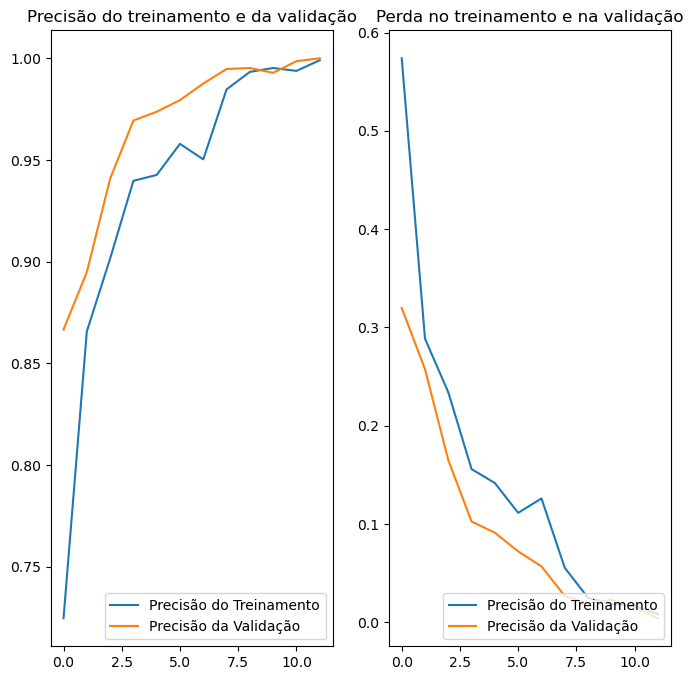

In [131]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Precisão do Treinamento")
plt.plot(epochs_range, val_acc, label="Precisão da Validação")
plt.legend(loc='lower right')
plt.title('Precisão do treinamento e da validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Precisão do Treinamento")
plt.plot(epochs_range, val_loss, label="Precisão da Validação")
plt.legend(loc='lower right')
plt.title('Perda no treinamento e na validação')

plt.show()

## Fazendo apenas uma predição

In [228]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('./testset/Saudavel/saudavel15.jpg', target_size = (180, 180))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
print(class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
['Cercosporiose', 'Ferrugem', 'Saudavel']


In [229]:
print(result)

[[-3.3161693 -6.1361904  8.211872 ]]


### Salvando o modelo

In [138]:
cnn.save("SicknessMinder_V3_1.keras")

### Abrindo o modelo

In [ ]:
cnn_V2_1 = load_model("SicknessMinder_V2_1.keras")
loss, accuracy = cnn_V2_1.evaluate(test_set)
print(f'Loss: {loss}, Accuracy: {accuracy}')